**NOTE**: `pylandtemp` module is not used in this notebook. Here, I have only shown how to load Landsat images from Google and Amazon cloud buckets

# 1.  Import python dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio

# 2. Location

For this tutorial, we’ll use the NIR and Red bands from a Landsat-8 scene above part of the central valley and the Sierra Nevada in California. We’ll be using Level 1TP datasets, orthorectified, map-projected images containing radiometrically calibrated data.

# 3. Amazon web services (AWS) and Google Cloud

You can use NASA’s Earthdata Search website to discover data. 
Landsat images are organized by ‘path’ and ‘row’. We’ve chosen a scenes from path 42, row 34, that doesn’t have many clouds present (LC08_L1TP_042034_20170616_20170629_01_T1). Note that ‘T1’ stands for ‘Tier 1’ (for analytic use), and ‘RT’ stands for ‘Real-time’, for which quality control is not as rigorous. 
Read more about the various Landsat formats and collections here. 

The advantage of this approach is that you do not need to download the image locally before perfroming your analysis. You can pull the image into your workspace from the cloud via image folder links as demonstrated below.

Finding and loading the data with both AWS or Google Cloud follow the same workflow. 

For example, look at the band 4 image for the date we selected below:

#### Google cloud sample link

In [2]:
print('Landsat on Google cloud:')
print('=========================')
filepath = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/"+\
            "042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF"

with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google cloud:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


# 4. Bands needed from land surface temperature computation
- Red: Band 4
- Near-Infrared (NIR): Band 5
- Thermal infrared 1: Band 10
- Thermal infrared 2: Band 11

Here, I have used `rasterio` to load the images/bands needed.

In [3]:
url = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/"+\
       "01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/"

#url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4) # L1TP_216074_20160531_20180528_01_T1_B4.TIF'
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)
tempband10 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(10)
tempband11 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(11)

In [4]:
with rasterio.open(url+redband) as src:
    redImage = src.read(1).astype('f4')

with rasterio.open(url+nirband) as src:
    nirImage = src.read(1).astype('f4')
    
with rasterio.open(url+tempband10) as src:
    tempImage10 = src.read(1).astype('f4')

with rasterio.open(url+tempband11) as src:
    tempImage11 = src.read(1).astype('f4')

### Visualize the Red and NIR band images

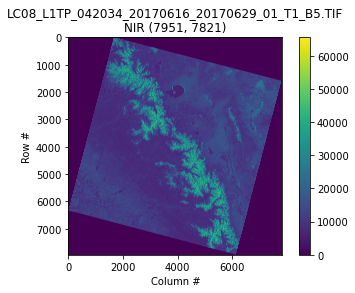

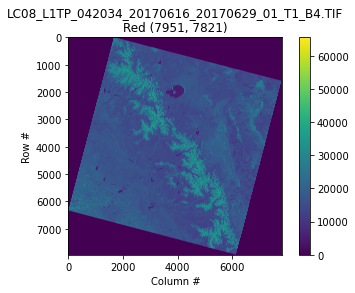

In [5]:
plt.imshow(redImage)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nirImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(nirImage)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, redImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

### Create a mask variable that will be used all through this notebook

The idea is that we do not want to compute or displace the land surface temperature over parts of the Thermal Infre-red image with reflactance values of zero. We can thus create a mask here to help improve our visualization of the thermal IR images. Note that this masking is automatically handled in the landtemp module. You won't have to create the mask by yourself.

In [6]:
# Creating and applying the mask to the images.
mask = tempImage10 == 0
tempImage10[mask] = np.nan
tempImage11[mask] = np.nan

### Visualize the  thermal IR bands (10 and 11)

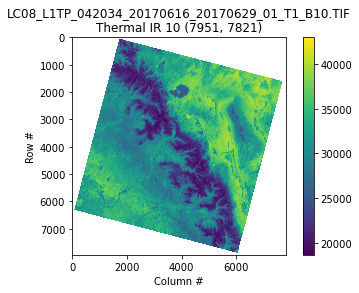

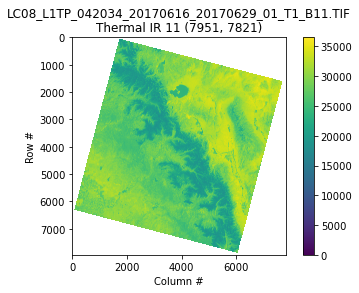

In [7]:
plt.imshow(tempImage10)
plt.colorbar()
plt.title('{}\nThermal IR 10 {}'.format(tempband10, tempImage10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(tempImage11)
plt.colorbar()
plt.title('{}\nThermal IR 11 {}'.format(tempband11, tempImage10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()